# **(PCA) of multidimensional points **


In this Jupyter notebook, we will be performing Principal Component Analysis (PCA) using the points provided is exp_2d_blobs using the easy approach.

---

### Imports

In [1]:
from time import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn.datasets import make_blobs
import pylab as pl
from sklearn.cluster import Birch, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
# from robotikos.metric import IdentityFeature
# from robotikos.metric import (NormalizedSumSquaredDiffMetric,
#                               NormalizedSumAbsDiffMetric)
from thetan.theta import theta_g1, assign
from thetan.theta import distance_matrix as tdm
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, silhouette_score, fowlkes_mallows_score

import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

### Load 4d data from exp_2d_blobs test.py

In [2]:
verbose = True
show_thr = False
evaluation_thr = 0.1
radius = 4
n_local_samples = 30
blob_dis = 33
cluster_per_dim = 10
blob_dis = 15
cluster_x = 10
cluster_y = 10
cluster_z = 10
cluster_u = 10
numberOfDimensions = 4
#measurement for centroid accuracy
#should be one 1000 clusters in 3dimensions 
xx = np.arange(-1*blob_dis*cluster_x//2, blob_dis*cluster_x//2, blob_dis)
yy = np.arange(-1*blob_dis*cluster_y//2, blob_dis*cluster_y//2, blob_dis)
zz = np.arange(-1*blob_dis*cluster_z//2, blob_dis*cluster_z//2, blob_dis)
uu = np.arange(-1*blob_dis*cluster_u//2, blob_dis*cluster_u//2, blob_dis)

xx, yy, zz, uu = np.meshgrid(xx, yy, zz, uu)
#of centers should be 1000
n_centres = np.hstack((np.ravel(xx)[:, np.newaxis],
                    np.ravel(yy)[:, np.newaxis], 
                    np.ravel(zz)[:,np.newaxis],
                    np.ravel(uu)[:,np.newaxis]))



gt_centroids = []
#here the number of dimensions is increased to 3 
# X = np.zeros((n_local_samples * n_centres.shape[0], 3))
X = np.zeros((n_local_samples * n_centres.shape[0], numberOfDimensions))
y = np.zeros((n_local_samples * n_centres.shape[0]), dtype=np.int16)
for i in range(n_centres.shape[0]):
    cpos = n_centres[i]

    local_X = cpos + np.random.normal(0, 1, (n_local_samples, numberOfDimensions))
    X[i * n_local_samples: (i + 1) * n_local_samples] = local_X
    y[i * n_local_samples: (i + 1) * n_local_samples] = i
    gt_centroids.append(local_X.mean(axis=0))

gt_centroids = np.array(gt_centroids)

points = X

labels = y
sz = len(n_centres)
print(sz)
centroids = gt_centroids
#put everything one line 
#goal for next week 
#plot X and y and attempt to plot up to 5 6 dimensions 
#create a function to return experiment set up 




print('Before shuffling')
print(points[:10])

points_idx = np.arange(np.shape(points)[0])
np.random.shuffle(points_idx)
new_points = np.zeros(np.shape(points))
new_labels = np.zeros(np.shape(labels))
for i, idx in zip(range(np.shape(points)[0]), points_idx):
    new_points[i] = points[idx]
    new_labels[i] = labels[idx]

points = new_points
labels = new_labels

print('After shuffling')
print(points[:10])
dfPoints = pd.DataFrame(points, columns = ['X','Y','Z', 'U'])



10000
Before shuffling
[[-73.89335992 -76.15218814 -74.81554563 -75.54086912]
 [-73.19182612 -74.82228085 -75.62286824 -75.72206223]
 [-74.52108602 -75.11410949 -75.79019005 -74.72547257]
 [-76.44058331 -73.33750165 -74.70657462 -74.59055573]
 [-73.26415028 -75.26786632 -75.33838062 -74.58402857]
 [-75.57329214 -75.59626465 -75.45456605 -75.29538113]
 [-74.95348388 -75.48386211 -73.63967071 -73.64652609]
 [-75.58417876 -75.21973278 -74.34776219 -75.11419169]
 [-76.43631257 -75.0502846  -75.52152738 -76.84068343]
 [-73.41791332 -73.16869164 -74.45773796 -74.34789739]]
After shuffling
[[ 30.47252232  30.1624475  -45.11468066  44.41155069]
 [-44.57662857  32.0375098  -16.07290741  45.51708337]
 [  0.20063057  44.56103615 -46.06683487 -76.23456034]
 [ 14.8947028  -73.76622978  29.50028513 -15.06120301]
 [ -2.32601772 -61.6773865  -45.06584726 -60.07614335]
 [-62.11256026 -59.83637728 -59.37872717 -30.79771328]
 [-76.32384957 -14.60260258  -0.2579998   -0.27146575]
 [-46.34363814   0.688109

In [3]:
print(points)

[[ 30.47252232  30.1624475  -45.11468066  44.41155069]
 [-44.57662857  32.0375098  -16.07290741  45.51708337]
 [  0.20063057  44.56103615 -46.06683487 -76.23456034]
 ...
 [-76.09636532 -45.39752231 -61.59801737  15.54618092]
 [-15.51146109  12.79848807 -74.19642294  29.59743598]
 [ 28.74416573 -74.86198154  60.32372572  58.57518957]]


# Performing kmeans++ and tm 

In [4]:
print(points)

[[ 30.47252232  30.1624475  -45.11468066  44.41155069]
 [-44.57662857  32.0375098  -16.07290741  45.51708337]
 [  0.20063057  44.56103615 -46.06683487 -76.23456034]
 ...
 [-76.09636532 -45.39752231 -61.59801737  15.54618092]
 [-15.51146109  12.79848807 -74.19642294  29.59743598]
 [ 28.74416573 -74.86198154  60.32372572  58.57518957]]


In [5]:
t1 = time()
kmeans = KMeans(n_clusters=np.prod(sz), init='k-means++', n_init=1,
                max_iter=300, tol=0.0001, random_state=0).fit(points)
t2 = time()

kmeans_time = t2 - t1
print('kmeans++ ', kmeans_time)

kcentroids = kmeans.cluster_centers_
klabels = kmeans.labels_
tmp = 0


#calculating theta centroids
theta = 6.0

t1 = time()
tcentroids, tlabels = theta_g1(points, theta=theta,)
t2 = time()

tm_time = t2 - t1
print('tm ', tm_time)

print("tshape")
print(tcentroids.shape)
print("kshape")
print(kcentroids.shape)

# dfTCentroids = pd.DataFrame(tcentroids, columns = ['X','Y','Z', 'U'])
# dfKCentroids = pd.DataFrame(kcentroids, columns = ['X','Y','Z', 'U'])
# # print(dfTCentroids)
# dftlabels = pd.DataFrame(tlabels)
# dfPoints['tlabel'] = dftlabels
# dfklabels = pd.DataFrame(klabels)
# dfPoints['klabel'] = dfklabels
# dfPoints.head()

kmeans++  531.9535872936249
tm  12.48039197921753
tshape
(10022, 4)
kshape
(10000, 4)


In [6]:
print("tshape")
print(tlabels.shape)
print("kshape")
print(klabels.shape)

tshape
(300000,)
kshape
(300000,)


### Input features

In [7]:
print(points)

[[ 30.47252232  30.1624475  -45.11468066  44.41155069]
 [-44.57662857  32.0375098  -16.07290741  45.51708337]
 [  0.20063057  44.56103615 -46.06683487 -76.23456034]
 ...
 [-76.09636532 -45.39752231 -61.59801737  15.54618092]
 [-15.51146109  12.79848807 -74.19642294  29.59743598]
 [ 28.74416573 -74.86198154  60.32372572  58.57518957]]


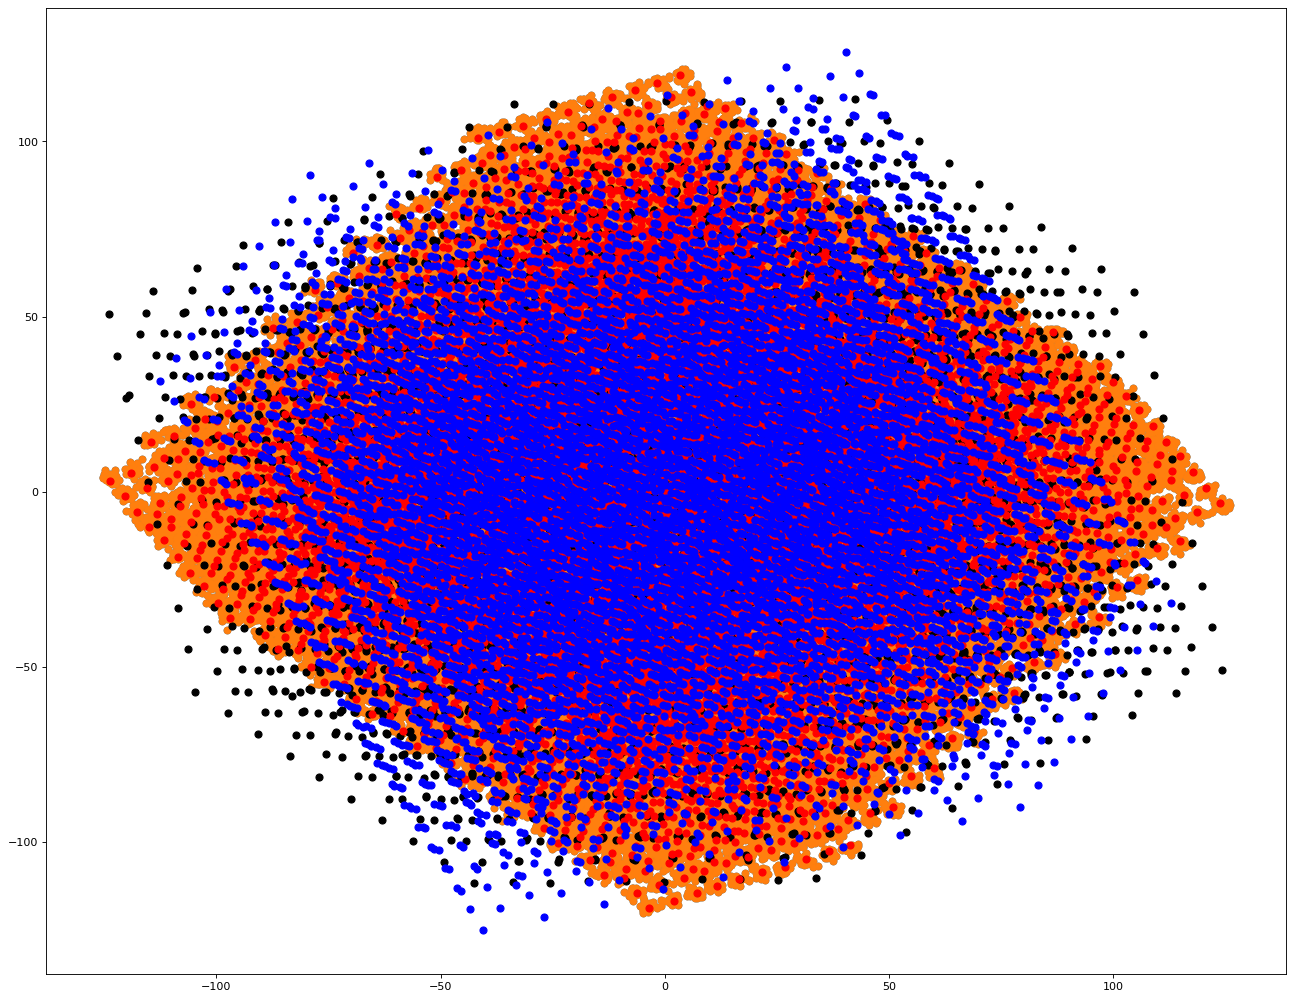

In [8]:
from matplotlib.pyplot import figure

figure(figsize=(20, 16), dpi=80)
#tcentroids
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
Xt = pca.fit_transform(points)
Tc = pca.fit_transform(tcentroids)
plot = plt.scatter(Xt[:,0], Xt[:,1])
# plt.legend(handles=plot.legend_elements()[0], labels=dfPoints['tlabels'])

#kcentroids
Kc = pca.fit_transform(kcentroids)
plot = plt.scatter(Xt[:,0], Xt[:,1])
Ac = pca.fit_transform(centroids)

plt.scatter(Kc[:,0] , Kc[:,1] , s = 40, color = 'black')
plt.scatter(Ac[:,0] , Ac[:,1] , s = 40, color = 'red')
plt.scatter(Tc[:,0] , Tc[:,1] , s = 40, color = 'blue')

plt.show()

#as the radius get smaller more errors will occur on km
#threshold is important for comparision, has to be smaller than theta 
# 4d data and get some accuracy measure of ground truth to calculated centroids

### Normalized Mutual Information (NMI) 
is a normalization of the Mutual Information (MI) score to scale the results between 0 (no mutual information) and 1 (perfect correlation). In this function, mutual information is normalized by some generalized mean of H(labels_true) and H(labels_pred)), defined by the average_method

### Silhouette Score
Compute the mean Silhouette Coefficient of all samples.

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

### Fowlkes_mallows_score
Measure the similarity of two clusterings of a set of points.

The Fowlkes-Mallows index (FMI) is defined as the geometric mean between of the precision and recall:

FMI = TP / sqrt((TP + FP) * (TP + FN))

In [9]:
from sklearn.metrics import normalized_mutual_info_score, silhouette_score, fowlkes_mallows_score

nmiScore = normalized_mutual_info_score(labels, klabels)
silScore = silhouette_score(points, klabels)
fmsScore = fowlkes_mallows_score(labels, klabels)

print(nmiScore)
print(silScore)
print(fmsScore)

0.9996261804038413
0.8000453250645408
0.9956462521387651


In [10]:
from sklearn.metrics import normalized_mutual_info_score, silhouette_score, fowlkes_mallows_score

nmiScore = normalized_mutual_info_score(labels, tlabels)
silScore = silhouette_score(points, tlabels)
fmsScore = fowlkes_mallows_score(labels, tlabels)

print(nmiScore)
print(silScore)
print(fmsScore)

0.9999513632982258
0.8041485224780743
0.9996996100553543


### Accuracy

In [11]:
from sklearn.metrics import accuracy_score
accuracy_score(labels, tlabels)

0.0002

### Note that spatial.distance.cosine computes the distance, and not the similarity. So, you must subtract the value from 1 to get the similarity.

In [12]:
from scipy import spatial

#similarity for tlabels
simlarityTLabels = 1 - spatial.distance.cosine(labels, tlabels)
print('similarity for tlabels')
print(simlarityTLabels)
#similarity for tlabels
print('distance for tlabels')
distanceTLabels = spatial.distance.cosine(labels, tlabels)
print(distanceTLabels)
print('similarity for klabels')
simlarityKLabels = 1 - spatial.distance.cosine(labels, klabels)
print(simlarityKLabels)
print('distance for klabels')
distanceKLabels = spatial.distance.cosine(labels, klabels)
print(distanceKLabels)

similarity for tlabels
0.7500807173751157
distance for tlabels
0.24991928262488428
similarity for klabels
0.7496545161355106
distance for klabels
0.2503454838644894


### Clustering metrics used to evaluate predictions


### Homogeneity_score
A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.

In [13]:
from sklearn.metrics.cluster import homogeneity_score
print('Homogeneity for tlabels')
homotlabels = homogeneity_score(labels, tlabels)
print(homotlabels)
print('Homogeneity for klabels')
homotlabels = homogeneity_score(labels, klabels)
print(homotlabels)


Homogeneity for tlabels
1.0
Homogeneity for klabels
0.9994568011209435


### Completeness_score
A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.

In [14]:
from sklearn.metrics.cluster import completeness_score
print('completeness_score for tlabels')
homotlabels = completeness_score(labels, tlabels)
print(homotlabels)
print('completeness_score for klabels')
homotlabels = completeness_score(labels, klabels)
print(homotlabels)


completeness_score for tlabels
0.9999027313272789
completeness_score for klabels
0.9997956171063379
